# GOAL

Examine the copy number states on clonal 3D7 samples predicted by a Gaussian Mixture HMM using similar methods as published papers on WGS anopheles and Plasmodium falciparum datasets, where read coverage in a window is only normalized by GC content. Compare the predictions across 3D7 samples prepared through WGS, gDNA (leukodpleted and unamplified), and sWGA protocols.

In [1]:
import os
import os
import glob
import re
import pandas
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from hmmlearn import hmm
import scipy.stats
# from sklearn import hmm
%matplotlib inline

In [2]:
PF_3D7_SWGA_COV_GC_TSV = os.path.abspath(os.getcwd() + "/../../data/pysamstats_gc/3D7_10-T1.12978906.unknown.pysamstats_gc.txt")
PF_3D7_WGA_COV_GC_TSV = os.path.abspath(os.getcwd() + "/../../data/pysamstats_gc/PG51-WGA.8356304.11142_2#2.pysamstats_gc.txt")
PF_3D7_GDNA_COV_GC_TSV = os.path.abspath(os.getcwd() + "/../../data/pysamstats_gc/PG51-gDNA.8356310.11142_2#8.pysamstats_gc.txt")


In [3]:
def get_norm_gc(pysam_gc_stats_tsv):
    # Per-position GC content, read coverage.  
    # We don't care about properly paired reads here, since there could be 
    # inversions, deletions, insertions that alter orientation of read pairs.
    pysam_gc = pandas.read_csv(pysam_gc_stats_tsv, sep="\t")
    # Indicate the window start position
    pysam_gc["window"] =  300 * (pysam_gc.pos // 300)
    
    # Aggregate reads by window
    pysam_gc_win = pysam_gc.groupby("window").agg({'gc': {"gc_win_med": "median", 'gc_win_mean': "mean"},
                                              'reads_all': {"reads_all_win_med": "median", 
                                                            'reads_all_win_mean': "mean"}})
    pysam_gc_win.columns = pysam_gc_win.columns.droplevel()
    # Label each window with the ave gc_bin content
    pysam_gc_win["gc_bin"] =  pysam_gc_win["gc_win_mean"].apply(np.floor)
    
    # Find the mean reads in each GC Bin
    pysam_gc_per_pos_per_win = pysam_gc.reset_index().set_index("window").join(pysam_gc_win[["gc_bin"]])

    pysam_by_gc_bin = pysam_gc_per_pos_per_win.groupby("gc_bin").agg({'reads_all': "mean"})
    pysam_by_gc_bin = pysam_by_gc_bin.rename(columns={'reads_all': 'reads_all_gc_bin_mean'})
    
    pysam_per_win_per_gc_bin = pysam_gc_win.reset_index().set_index("gc_bin").join(pysam_by_gc_bin, rsuffix="_median")
    pysam_per_win_per_gc_bin = pysam_per_win_per_gc_bin.reset_index()
    pysam_per_win_per_gc_bin["window"] = pysam_per_win_per_gc_bin["window"].astype(float)
    pysam_per_win_per_gc_bin = pysam_per_win_per_gc_bin.sort_values("window")
    
    pysam_per_win_per_gc_bin["norm_reads_all"] = pysam_per_win_per_gc_bin["reads_all_win_mean"] / pysam_per_win_per_gc_bin["reads_all_gc_bin_mean"]

    
    
    return pysam_per_win_per_gc_bin


In [4]:

def fit_hmm(depth_normed,  # normalised coverage array 
            transition_probability,  # probability of state transition
            variance,  # variance per copy 
            variance_fixed,  # variance for the zero copy number state 
            min_swga_copy_number=0,  # minimum copy number to consider in the model
            max_swga_copy_number=5,  # maximum copy number to consider in the model 
            n_iter=0,  # number of iterations to perform when fitting the model
            params='st',  # parameters that can be changed through fitting 
            init_params='',  # parameters that are initialised from the data
           ):
    
    # convenience variable
    n_states = max_swga_copy_number - min_swga_copy_number
    
    # construct the transition matrix
    transmat = np.zeros((n_states, n_states))
    transmat[:] = transition_probability
    transmat[np.diag_indices(n_states)] = 1-((n_states-1)*transition_probability)
    display("transmat")
    display(transmat)

    # construct means and covariance
    means = np.array([[n] for n in range(min_swga_copy_number, max_swga_copy_number)])
    covars = np.array([[variance*n + variance_fixed] for n in range(min_swga_copy_number, max_swga_copy_number)])

    # setup HMM 
    model = hmm.GaussianHMM(n_states, 
                        covariance_type='diag', 
                        n_iter=n_iter, 
                        transmat_prior=transmat, 
                        params=params,
                        init_params=init_params)
    model.means_ = means
    model.covars_ = covars
    
    # fit HMM
    obs = np.column_stack([depth_normed])
    display("obs")
    display(obs)
#     obs = depth_normed
    model.fit(obs)
    
    # predict hidden states
    h = model.predict(obs)
    
    return h

# 3D7  SWGA

In [5]:
pf_3d7_swga_gc = get_norm_gc(pysam_gc_stats_tsv=PF_3D7_SWGA_COV_GC_TSV)
pf_3d7_swga_gc["protocol"] = "sWGA"
pf_3d7_swga_gc["copy_number"] = fit_hmm(depth_normed =pf_3d7_swga_gc["norm_reads_all"].values,  
                      transition_probability=.01,
                      variance=.1,
                      variance_fixed=.001)
display(pf_3d7_swga_gc.shape)
display(pf_3d7_swga_gc)
display(pf_3d7_swga_gc.describe())

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


'transmat'

array([[ 0.96,  0.01,  0.01,  0.01,  0.01],
       [ 0.01,  0.96,  0.01,  0.01,  0.01],
       [ 0.01,  0.01,  0.96,  0.01,  0.01],
       [ 0.01,  0.01,  0.01,  0.96,  0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.96]])

'obs'

array([[ 1.        ],
       [ 0.89234472],
       [ 0.01733979],
       ..., 
       [ 0.33729737],
       [ 1.        ],
       [ 3.89284201]])

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


(4425, 10)

,gc_bin,window,gc_win_med,gc_win_mean,reads_all_win_mean,reads_all_win_med,reads_all_gc_bin_mean,norm_reads_all,protocol,copy_number
4422,47.0,0.0,47.0,47.098592,16.235915,17.0,16.235915,1.000000,sWGA,1
4405,41.0,300.0,42.0,41.013825,18.884793,21.0,21.163114,0.892345,sWGA,1
4293,32.0,3000.0,33.0,32.550000,1.000000,1.0,57.670817,0.017340,sWGA,0
4294,32.0,3300.0,33.0,32.910000,1.000000,1.0,57.670817,0.017340,sWGA,0
4295,32.0,8100.0,33.0,32.758929,1.000000,1.0,57.670817,0.017340,sWGA,0
4268,31.0,8400.0,32.0,31.875000,1.000000,1.0,103.857810,0.009629,sWGA,0
4296,32.0,9900.0,32.0,32.030000,1.000000,1.0,57.670817,0.017340,sWGA,0
4269,31.0,13500.0,31.0,31.240000,1.000000,1.0,103.857810,0.009629,sWGA,0
4270,31.0,13800.0,32.0,31.630000,1.000000,1.0,103.857810,0.009629,sWGA,0
4297,32.0,14700.0,33.0,32.891566,1.000000,1.0,57.670817,0.017340,sWGA,0


,gc_bin,window,gc_win_med,gc_win_mean,reads_all_win_mean,reads_all_win_med,reads_all_gc_bin_mean,norm_reads_all,copy_number
count,4425.000000,4.425000e+03,4425.000000,4425.000000,4425.000000,4425.000000,4425.000000,4425.000000,4425.000000
mean,18.668249,6.785835e+05,19.163955,19.166845,200.976715,201.584859,201.287319,0.996217,1.223503
std,6.102148,3.833047e+05,6.217507,6.090199,187.043927,188.306638,45.651083,0.884475,0.683034
min,1.000000,0.000000e+00,1.000000,1.573333,1.000000,1.000000,1.000000,0.006515,0.000000
25%,14.000000,3.468000e+05,15.000000,14.666667,94.133333,94.000000,186.514081,0.472136,1.000000
50%,18.000000,6.786000e+05,19.000000,18.866667,150.000000,151.000000,222.546025,0.760572,1.000000
75%,22.000000,1.010400e+06,23.000000,22.690000,239.466667,239.000000,225.123660,1.188936,1.000000
max,51.000000,1.343400e+06,52.000000,51.750000,1687.793333,1729.000000,260.971865,7.154946,4.000000


# WGA (Whole Genome Amplified)

In [6]:
pf_3d7_wga_gc = get_norm_gc(pysam_gc_stats_tsv=PF_3D7_WGA_COV_GC_TSV)
pf_3d7_wga_gc["protocol"] = "WGA"
pf_3d7_wga_gc["copy_number"] = fit_hmm(depth_normed =pf_3d7_wga_gc["norm_reads_all"].values,  
                      transition_probability=.01,
                      variance=.1,
                      variance_fixed=.001)
display(pf_3d7_wga_gc.shape)
display(pf_3d7_wga_gc)
display(pf_3d7_wga_gc.describe())

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


'transmat'

array([[ 0.96,  0.01,  0.01,  0.01,  0.01],
       [ 0.01,  0.96,  0.01,  0.01,  0.01],
       [ 0.01,  0.01,  0.96,  0.01,  0.01],
       [ 0.01,  0.01,  0.01,  0.96,  0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.96]])

'obs'

array([[ 0.0717151 ],
       [ 0.05902651],
       [ 0.08580635],
       ..., 
       [ 0.07401764],
       [ 0.83756211],
       [ 1.44720556]])

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


(4475, 10)

,gc_bin,window,gc_win_med,gc_win_mean,reads_all_win_mean,reads_all_win_med,reads_all_gc_bin_mean,norm_reads_all,protocol,copy_number
4423,37.0,300.0,37.0,37.102439,2.756098,3.0,38.431201,0.071715,WGA,0
4092,28.0,600.0,28.0,28.112727,2.970909,3.0,50.331773,0.059027,WGA,0
3894,26.0,900.0,26.0,26.716667,4.290000,4.0,49.996303,0.085806,WGA,0
4276,31.0,1200.0,32.0,31.523333,5.350000,6.0,32.211238,0.166091,WGA,1
4311,32.0,1500.0,33.0,32.516667,3.653333,4.0,34.824598,0.104907,WGA,0
4093,28.0,1800.0,28.0,28.616667,7.503333,7.0,50.331773,0.149077,WGA,1
4013,27.0,2100.0,28.0,27.703333,10.950000,11.0,52.112616,0.210122,WGA,1
4014,27.0,2400.0,28.0,27.840000,13.453333,14.0,52.112616,0.258159,WGA,1
4164,29.0,2700.0,30.0,29.966667,14.526667,14.0,43.513446,0.333843,WGA,1
4312,32.0,3000.0,32.0,32.440000,11.480000,11.0,34.824598,0.329652,WGA,1


,gc_bin,window,gc_win_med,gc_win_mean,reads_all_win_mean,reads_all_win_med,reads_all_gc_bin_mean,norm_reads_all,copy_number
count,4475.000000,4.475000e+03,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000
mean,18.837095,6.719943e+05,19.332961,19.334887,46.514746,46.474190,46.523531,0.999736,1.159330
std,6.218173,3.879394e+05,6.331821,6.206251,23.703886,23.751269,7.469839,0.485508,0.403216
min,1.000000,3.000000e+02,1.000000,1.000000,1.000000,1.000000,1.279605,0.042110,0.000000
25%,14.000000,3.358500e+05,15.000000,14.733333,29.598333,29.000000,41.345296,0.656071,1.000000
50%,18.000000,6.723000e+05,19.000000,18.970000,41.626667,42.000000,50.138543,0.907462,1.000000
75%,22.000000,1.007850e+06,23.000000,22.861667,58.560000,59.000000,52.279591,1.235825,1.000000
max,49.000000,1.343400e+06,50.000000,49.553333,161.840000,164.000000,63.066667,3.483163,3.000000


# Unamplified gDNA

In [7]:
pf_3d7_gdna_gc = get_norm_gc(pysam_gc_stats_tsv=PF_3D7_GDNA_COV_GC_TSV)
pf_3d7_gdna_gc["protocol"] = "gDNA"
pf_3d7_gdna_gc["copy_number"] = fit_hmm(depth_normed =pf_3d7_gdna_gc["norm_reads_all"].values,  
                      transition_probability=.01,
                      variance=.1,
                      variance_fixed=.001)
display(pf_3d7_gdna_gc.shape)
display(pf_3d7_gdna_gc)
display(pf_3d7_gdna_gc.describe())

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


'transmat'

array([[ 0.96,  0.01,  0.01,  0.01,  0.01],
       [ 0.01,  0.96,  0.01,  0.01,  0.01],
       [ 0.01,  0.01,  0.96,  0.01,  0.01],
       [ 0.01,  0.01,  0.01,  0.96,  0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.96]])

'obs'

array([[ 1.        ],
       [ 0.99409035],
       [ 0.95680669],
       ..., 
       [ 1.09727827],
       [ 1.        ],
       [ 1.20768126]])

/Users/tn6/anaconda3/envs/analysis_py35_mac/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


(4479, 10)

,gc_bin,window,gc_win_med,gc_win_mean,reads_all_win_mean,reads_all_win_med,reads_all_gc_bin_mean,norm_reads_all,protocol,copy_number
4477,47.0,0.0,47.0,47.195286,25.053872,26.0,25.053872,1.000000,gDNA,1
4449,39.0,300.0,39.0,39.103333,52.226667,49.0,52.537143,0.994090,gDNA,1
4095,28.0,600.0,28.0,28.236667,64.586667,64.0,67.502315,0.956807,gDNA,1
3897,26.0,900.0,26.0,26.716667,56.593333,55.0,68.768067,0.822959,gDNA,1
4279,31.0,1200.0,32.0,31.523333,60.113333,60.0,60.202476,0.998519,gDNA,1
4314,32.0,1500.0,33.0,32.516667,55.930000,56.0,59.697586,0.936889,gDNA,1
4096,28.0,1800.0,28.0,28.616667,58.666667,59.0,67.502315,0.869106,gDNA,1
4016,27.0,2100.0,28.0,27.703333,66.946667,66.5,66.990380,0.999347,gDNA,1
4017,27.0,2400.0,28.0,27.840000,62.810000,63.0,66.990380,0.937597,gDNA,1
4167,29.0,2700.0,30.0,29.966667,66.200000,65.0,65.443277,1.011563,gDNA,1


,gc_bin,window,gc_win_med,gc_win_mean,reads_all_win_mean,reads_all_win_med,reads_all_gc_bin_mean,norm_reads_all,copy_number
count,4479.000000,4.479000e+03,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000
mean,18.831882,6.717000e+05,19.328533,19.330248,67.547972,67.490400,67.546894,1.000022,1.000670
std,6.246471,3.879361e+05,6.359631,6.234006,9.596360,9.602141,3.851723,0.130846,0.025875
min,1.000000,0.000000e+00,1.000000,1.573333,25.053872,26.000000,25.053872,0.488896,1.000000
25%,14.000000,3.358500e+05,15.000000,14.731667,61.528333,62.000000,64.601739,0.924189,1.000000
50%,18.000000,6.717000e+05,19.000000,18.966667,68.493333,68.000000,68.751677,1.009672,1.000000
75%,22.000000,1.007550e+06,23.000000,22.861667,74.286667,74.000000,70.532476,1.083632,1.000000
max,49.000000,1.343400e+06,50.000000,49.553333,142.930000,142.000000,86.511667,1.978135,2.000000


# Compare Coverage Along Genome

In [8]:
cmp = pf_3d7_swga_gc.append(pf_3d7_wga_gc).append(pf_3d7_gdna_gc)
display(cmp.shape)
display(cmp)
display(cmp.describe())

(13379, 10)

,gc_bin,window,gc_win_med,gc_win_mean,reads_all_win_mean,reads_all_win_med,reads_all_gc_bin_mean,norm_reads_all,protocol,copy_number
4422,47.0,0.0,47.0,47.098592,16.235915,17.0,16.235915,1.000000,sWGA,1
4405,41.0,300.0,42.0,41.013825,18.884793,21.0,21.163114,0.892345,sWGA,1
4293,32.0,3000.0,33.0,32.550000,1.000000,1.0,57.670817,0.017340,sWGA,0
4294,32.0,3300.0,33.0,32.910000,1.000000,1.0,57.670817,0.017340,sWGA,0
4295,32.0,8100.0,33.0,32.758929,1.000000,1.0,57.670817,0.017340,sWGA,0
4268,31.0,8400.0,32.0,31.875000,1.000000,1.0,103.857810,0.009629,sWGA,0
4296,32.0,9900.0,32.0,32.030000,1.000000,1.0,57.670817,0.017340,sWGA,0
4269,31.0,13500.0,31.0,31.240000,1.000000,1.0,103.857810,0.009629,sWGA,0
4270,31.0,13800.0,32.0,31.630000,1.000000,1.0,103.857810,0.009629,sWGA,0
4297,32.0,14700.0,33.0,32.891566,1.000000,1.0,57.670817,0.017340,sWGA,0


,gc_bin,window,gc_win_med,gc_win_mean,reads_all_win_mean,reads_all_win_med,reads_all_gc_bin_mean,norm_reads_all,copy_number
count,13379.000000,1.337900e+04,13379.000000,13379.000000,13379.000000,13379.000000,13379.000000,13379.000000,13379.000000
mean,18.779505,6.740751e+05,19.275581,19.277755,104.643308,104.811608,104.748616,0.998668,1.127439
std,6.189618,3.863957e+05,6.303639,6.177503,128.252397,129.027360,73.435909,0.585887,0.466529
min,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,0.006515,0.000000
25%,14.000000,3.394500e+05,15.000000,14.715000,49.053333,49.000000,51.902317,0.691566,1.000000
50%,18.000000,6.741000e+05,19.000000,18.933333,68.416667,68.000000,67.819477,0.953998,1.000000
75%,22.000000,1.008600e+06,23.000000,22.801667,100.435000,100.500000,186.514081,1.123940,1.000000
max,51.000000,1.343400e+06,52.000000,51.750000,1687.793333,1729.000000,260.971865,7.154946,4.000000


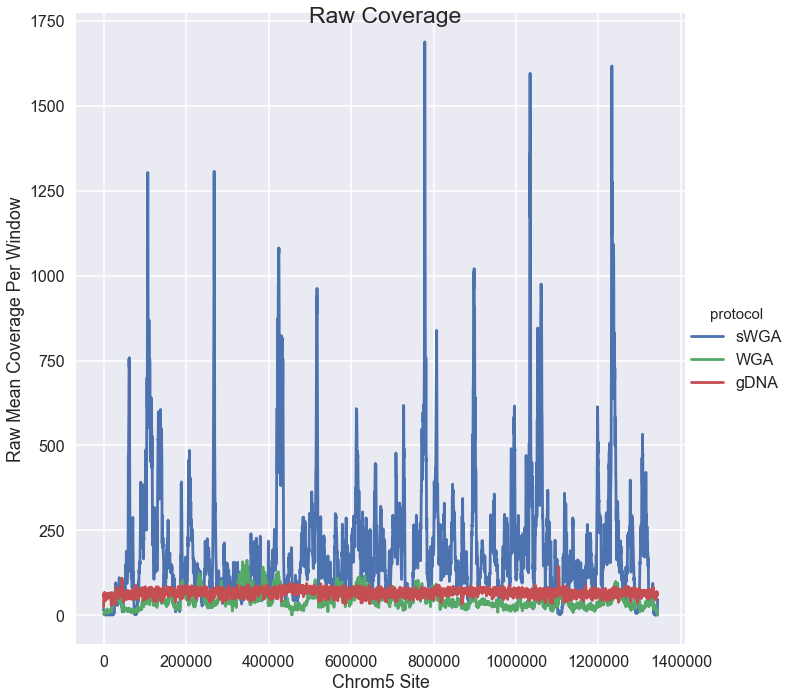

In [9]:
sns.set_context("poster")
g = sns.FacetGrid(data=cmp, hue="protocol", size=10)
g = g.map(plt.plot, "window", "reads_all_win_mean")
g.add_legend()
g.set_ylabels("Raw Mean Coverage Per Window")
g.set_xlabels("Chrom5 Site")
g.fig.suptitle("Raw Coverage")
plt.show()   

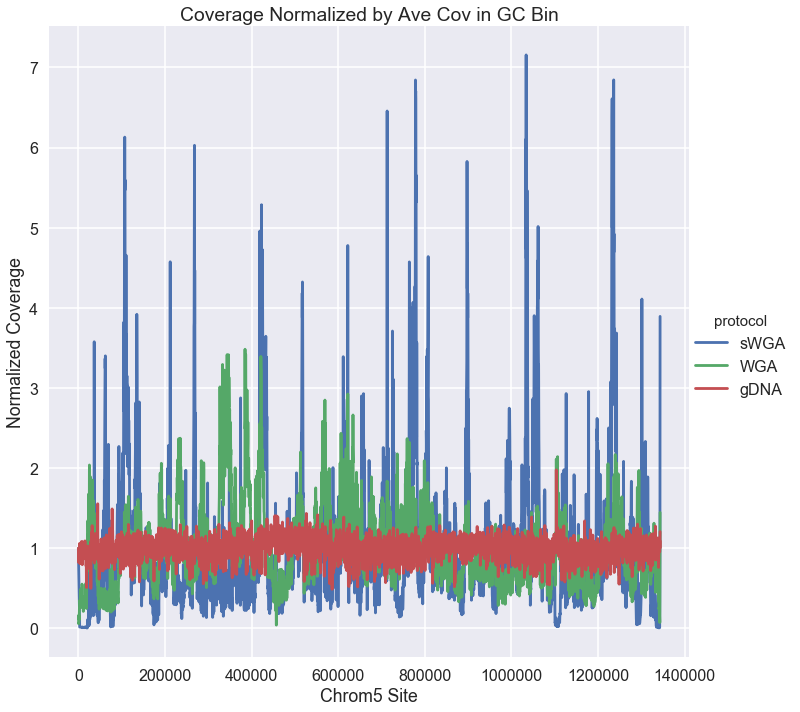

In [10]:
sns.set_context("poster")
g = sns.FacetGrid(data=cmp, hue="protocol", size=10)
g = g.map(plt.plot, "window", "norm_reads_all")
g.add_legend()
g.set_ylabels("Normalized Coverage")
g.set_xlabels("Chrom5 Site")
sns.plt.title("Coverage Normalized by Ave Cov in GC Bin")
plt.show()   

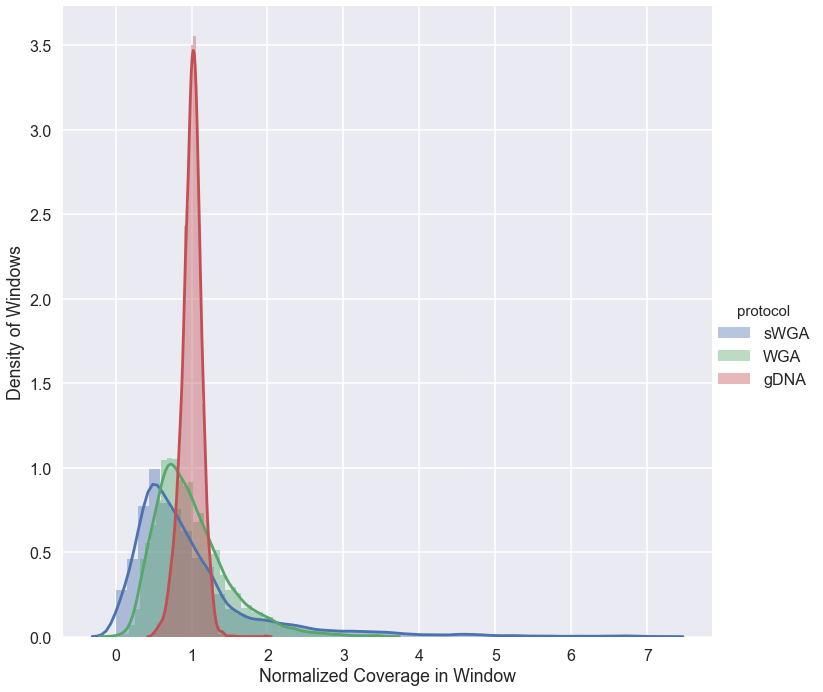

In [11]:
g = sns.FacetGrid(data=cmp, hue="protocol", size=10)
g = g.map(sns.distplot, "norm_reads_all")
g.set_ylabels("Density of Windows")
g.set_xlabels("Normalized Coverage in Window")
g.add_legend();
plt.show() 

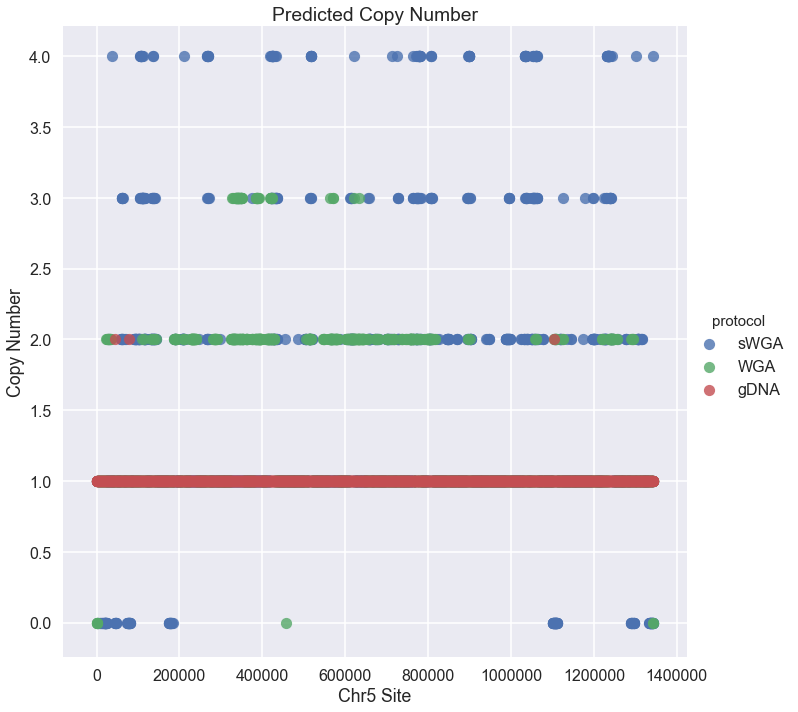

In [12]:
sns.set_context("poster")
g = sns.FacetGrid(data=cmp, hue="protocol", size=10)
g = g.map(sns.regplot, "window", "copy_number", fit_reg=False)
# g = g.map(plt.plot, "window", "copy_number")
g.set_ylabels("Copy Number")
g.set_xlabels("Chr5 Site")
g.add_legend()
sns.plt.title("Predicted Copy Number")
plt.show()   

In [13]:
pf_3d7_gdna_gc[pf_3d7_gdna_gc["copy_number"] > 1]

,gc_bin,window,gc_win_med,gc_win_mean,reads_all_win_mean,reads_all_win_med,reads_all_gc_bin_mean,norm_reads_all,protocol,copy_number
3397,23.0,44700.0,24.0,23.486667,109.17,114.0,70.187415,1.555407,gDNA,2
4419,36.0,78000.0,37.5,36.540000,88.36,62.0,59.249697,1.491316,gDNA,2
3358,22.0,1103700.0,23.0,22.983333,142.93,142.0,72.254919,1.978135,gDNA,2


# Get the xHMM results

In [37]:
xHMM_OUT_TSV = "/Volumes/lustre/scratch118/malaria/team112/personal/tn6/pf_swga_cnv/output/xhmm/xhmm_test.chr5.xcnv.win300.tsv"
xhmm_out = pandas.read_csv(xHMM_OUT_TSV, sep="\t")
display(xhmm_out.shape)
display(xhmm_out.head())
display(xhmm_out.describe())

(3602, 3)

,sample,window,copy_number
0,PF1155-CW,209400,2
1,PF1155-CW,209700,2
2,PF1155-CW,210000,2
3,PF1155-CW,210300,2
4,PF1155-CW,210600,2


,window,copy_number
count,3.602000e+03,3602.000000
mean,6.661622e+05,1.170461
std,3.996745e+05,0.985501
min,2.700000e+04,0.000000
25%,2.166000e+05,0.000000
50%,7.020000e+05,2.000000
75%,1.036725e+06,2.000000
max,1.333500e+06,2.000000


In [54]:
xhmm_3d7 = xhmm_out[xhmm_out["sample"] == "3D7_10-T1"]
# xhmm_3d7 = xhmm_out[xhmm_out["sample"] == "PF1025-CxW"]
display(xhmm_3d7.shape)
display(xhmm_3d7.head())
display(xhmm_3d7.describe())
# There are no copy number variants in 3D7

(0, 3)

,sample,window,copy_number


,window,copy_number
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [64]:
xhmm_3d7 = pandas.DataFrame([{"window": "0", "copy_number": 1}], 
                            columns=['window', 'copy_number'])  # Force a window that is 1 copy number
display(xhmm_3d7)
# join together to show that all windows are 1 for plotting
swga = pf_3d7_swga_gc.reset_index().set_index("window").join(xhmm_3d7.set_index("window"), lsuffix=".gauss", rsuffix=".xhmm")
swga.loc[pandas.isnull(swga["copy_number.xhmm"]), "copy_number.xhmm"] = 1
swga.index.name = "window"
swga = swga.reset_index()
display(swga.shape)
display(swga.head())
display(swga.describe())


,window,copy_number
0,0,1


(4425, 12)

,window,index,gc_bin,gc_win_med,gc_win_mean,reads_all_win_mean,reads_all_win_med,reads_all_gc_bin_mean,norm_reads_all,protocol,copy_number.gauss,copy_number.xhmm
0,0.0,4422,47.0,47.0,47.098592,16.235915,17.0,16.235915,1.000000,sWGA,1,1.0
1,300.0,4405,41.0,42.0,41.013825,18.884793,21.0,21.163114,0.892345,sWGA,1,1.0
2,3000.0,4293,32.0,33.0,32.550000,1.000000,1.0,57.670817,0.017340,sWGA,0,1.0
3,3300.0,4294,32.0,33.0,32.910000,1.000000,1.0,57.670817,0.017340,sWGA,0,1.0
4,8100.0,4295,32.0,33.0,32.758929,1.000000,1.0,57.670817,0.017340,sWGA,0,1.0


,window,index,gc_bin,gc_win_med,gc_win_mean,reads_all_win_mean,reads_all_win_med,reads_all_gc_bin_mean,norm_reads_all,copy_number.gauss,copy_number.xhmm
count,4.425000e+03,4425.0000,4425.000000,4425.000000,4425.000000,4425.000000,4425.000000,4425.000000,4425.000000,4425.000000,4425.0
mean,6.785835e+05,2212.0000,18.668249,19.163955,19.166845,200.976715,201.584859,201.287319,0.996217,1.223503,1.0
std,3.833047e+05,1277.5318,6.102148,6.217507,6.090199,187.043927,188.306638,45.651083,0.884475,0.683034,0.0
min,0.000000e+00,0.0000,1.000000,1.000000,1.573333,1.000000,1.000000,1.000000,0.006515,0.000000,1.0
25%,3.468000e+05,1106.0000,14.000000,15.000000,14.666667,94.133333,94.000000,186.514081,0.472136,1.000000,1.0
50%,6.786000e+05,2212.0000,18.000000,19.000000,18.866667,150.000000,151.000000,222.546025,0.760572,1.000000,1.0
75%,1.010400e+06,3318.0000,22.000000,23.000000,22.690000,239.466667,239.000000,225.123660,1.188936,1.000000,1.0
max,1.343400e+06,4424.0000,51.000000,52.000000,51.750000,1687.793333,1729.000000,260.971865,7.154946,4.000000,1.0


In [65]:
swga_long = pandas.melt(swga, id_vars=["window"], value_vars=["copy_number.gauss", "copy_number.xhmm"], 
                        var_name="protocol", value_name="copy_number")
swga_long.loc[swga_long["protocol"] == "copy_number.gauss", "protocol"] = "sWGA GaussHMM"
swga_long.loc[swga_long["protocol"] == "copy_number.xhmm", "protocol"] = "sWGA xHMM"
display(swga_long.shape)
display(swga_long.head())
display(swga_long.describe())

(8850, 3)

,window,protocol,copy_number
0,0.0,sWGA GaussHMM,1.0
1,300.0,sWGA GaussHMM,1.0
2,3000.0,sWGA GaussHMM,0.0
3,3300.0,sWGA GaussHMM,0.0
4,8100.0,sWGA GaussHMM,0.0


,window,copy_number
count,8.850000e+03,8850.000000
mean,6.785835e+05,1.111751
std,3.832831e+05,0.495713
min,0.000000e+00,0.000000
25%,3.468000e+05,1.000000
50%,6.786000e+05,1.000000
75%,1.010400e+06,1.000000
max,1.343400e+06,4.000000


In [66]:
cmp = swga_long[swga_long["protocol"] == "sWGA GaussHMM"].append(
    pf_3d7_gdna_gc[["window", "copy_number", "protocol"]]).append(
    pf_3d7_wga_gc[["window", "copy_number", "protocol"]]).append(
    swga_long[swga_long["protocol"] == "sWGA xHMM"])

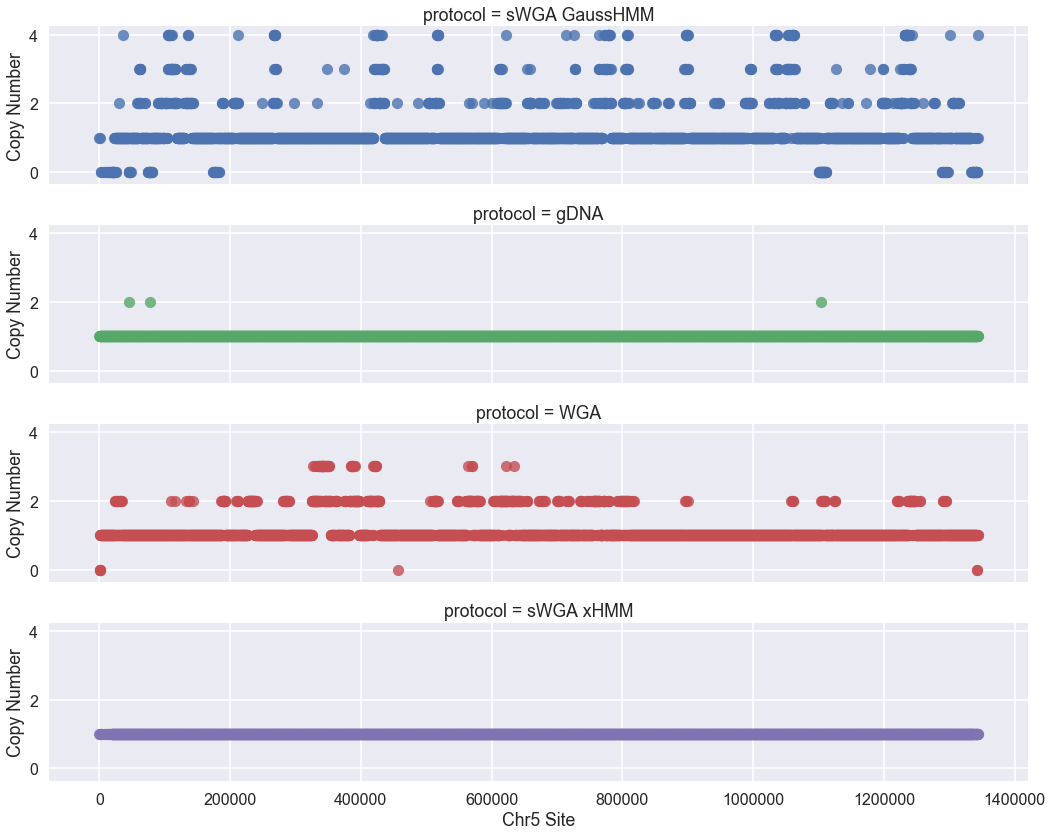

In [67]:
sns.set_context("poster")
g = sns.FacetGrid(data=cmp, row="protocol", hue="protocol", aspect=5)
g = g.map(sns.regplot, "window", "copy_number", fit_reg=False)
# g = g.map(plt.plot, "window", "copy_number")cmp
g.set_ylabels("Copy Number")
g.set_xlabels("Chr5 Site")
plt.show()   